In [1]:
# for data load
import os
import numpy as np
import nibabel as nib
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
# for reading and processing images
import imageio
from PIL import Image
import skimage.transform as skTrans
# for visualizations
import matplotlib.pyplot as plt
# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [ ]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install imageio


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install nibabel

In [26]:
image_dir_r = r"C:\\Users\\Dharuneswar Kumar\\Downloads\\right\\rimg"
#output_dir =r"/content/drive/MyDrive/Dataset/output"
mask_dir_r = r"C:\\Users\\Dharuneswar Kumar\\Downloads\\right\\rmask"
image_dir_l = r"C:\\Users\\Dharuneswar Kumar\\Downloads\\left\\limg"
#output_dir =r"/content/drive/MyDrive/Dataset/output"
mask_dir_l = r"C:\\Users\\Dharuneswar Kumar\\Downloads\\left\\lmask"


'image_files = os.listdir(image_dir)\nmask_files = os.listdir(mask_dir)\n # Process each slice individually\nfor img_file,mask_file in zip(image_files,mask_files):\n    img_path = os.path.join(image_dir, img_file)\n    mask_path = os.path.join(mask_dir, mask_file)\n    # Load the image\n    img = nib.load(img_path)\n    mask_img = nib.load(mask_path).get_fdata()\n    imgdata=img.get_fdata()\n    if imgdata is None:\n        print(f"Error loading image: {img_path}")\n        continue  # Skip to the next image\n    # Rotate the volume\n    rotated_data = rotate_volume(imgdata)\n    rotated_mask_img = rotate_volume(mask_img)\n    # Get depth (number of slices)\n    depth = rotated_data.shape[2]\n    # Process each slice individually\n\n    processed_ct_img = np.zeros_like(rotated_data)\n    for i in range(60,80):\n        img_slice = rotated_data[:,:,i]\n        mask_slice = rotated_mask_img[:,:,i]\n        masked_ct_slice = np.where(mask_slice > 0, img_slice, 0)\n        processed_ct_img

In [27]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)
    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)
    return orig_img, mask_img

In [28]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    # Resize images and masks
    for index,file in enumerate(img):
        path = os.path.join(path1, file)
        single_img = nib.load(path).get_fdata()
        index =img.index(file)
        single_img_max_proj = np.max(single_img, axis=2)
        # convert image into an array of desired shape (3 channels)
        single_img = skTrans.resize(single_img_max_proj, (i_h,i_w), order=1, preserve_range=True)
        # Create artificial channels by duplicating the single channel across all three channels
        single_img = np.stack((single_img,) * 3, axis=-1)
        # Normalize pixel values to be in the range [0, 1]

        X[index] = single_img/255.0

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = nib.load(path).get_fdata()
        single_mask_max_proj = np.max(single_img, axis=2)
        single_mask = skTrans.resize(single_mask_max_proj,(m_h, m_w), order=1, preserve_range=True)
        single_mask = np.expand_dims(single_mask, axis=-1)
        single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask
    return X, y

In [29]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

In [30]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [31]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):



    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output
    """
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [218]:
""" Load Train Set and view some examples """
def loadimages(image_dir,mask_dir):
# Call the apt function
    path1 = image_dir
    path2 = mask_dir
    img, mask = LoadData (path1, path2)

# View an example of image and corresponding mask
    show_images = 1
    for i in range(show_images):
        img_view = nib.load(os.path.join(path1,img[i])).get_fdata()
        mask_view = nib.load(os.path.join(path2,mask[i])).get_fdata()

        for i in range(200,210):
            img_slice = img_view[:,:,i]
            mask_slice = mask_view[:,:,i]
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img_slice, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask_slice, cmap='gray')
            plt.title('Mask Image')
            plt.axis('off')
    return img,mask


#for left side image

X left Shape: (20, 128, 128, 3)
Y left shape: (20, 128, 128, 1)
[0 1 2]


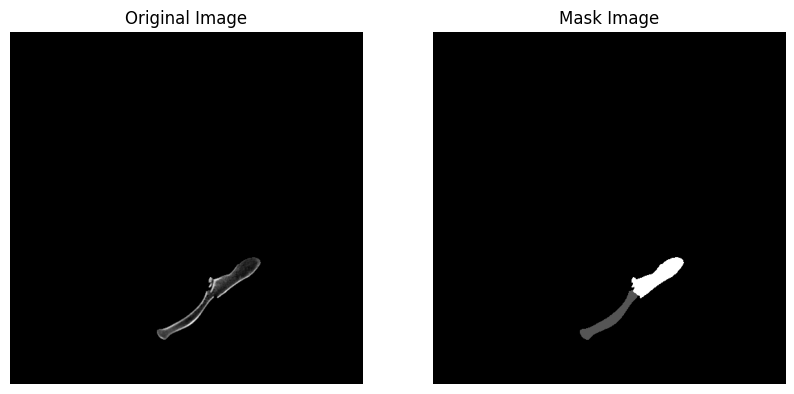

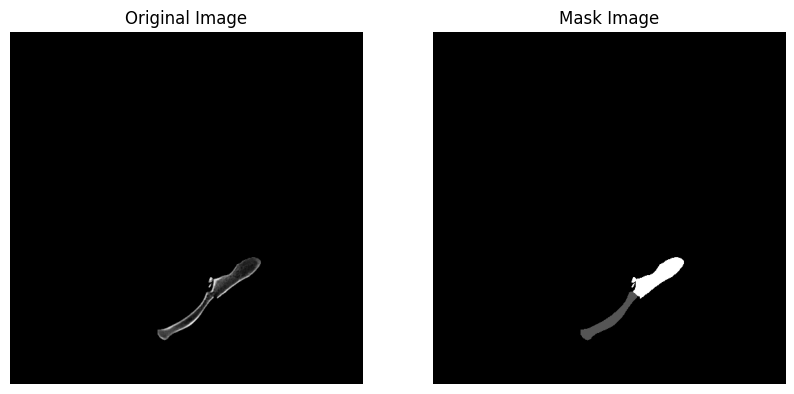

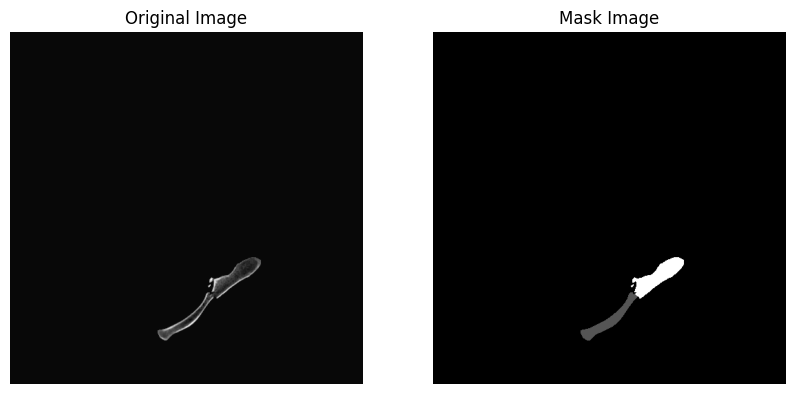

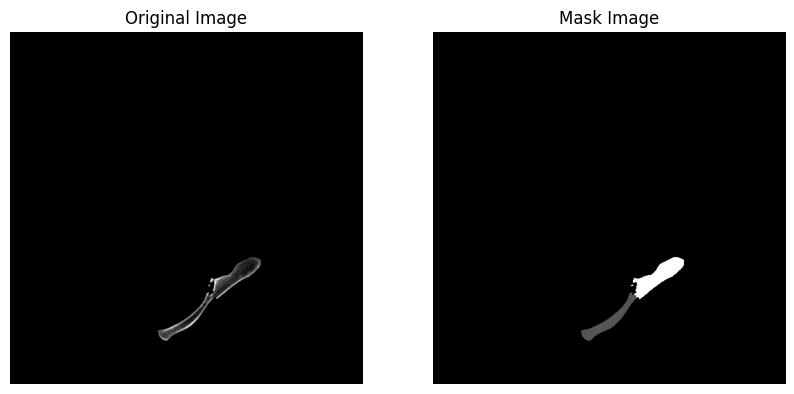

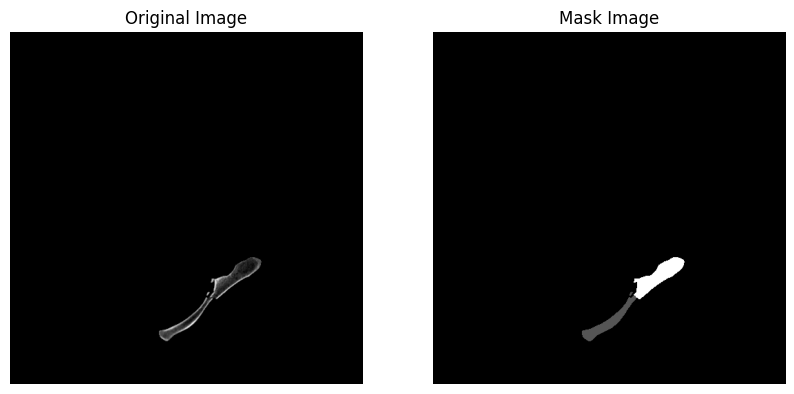

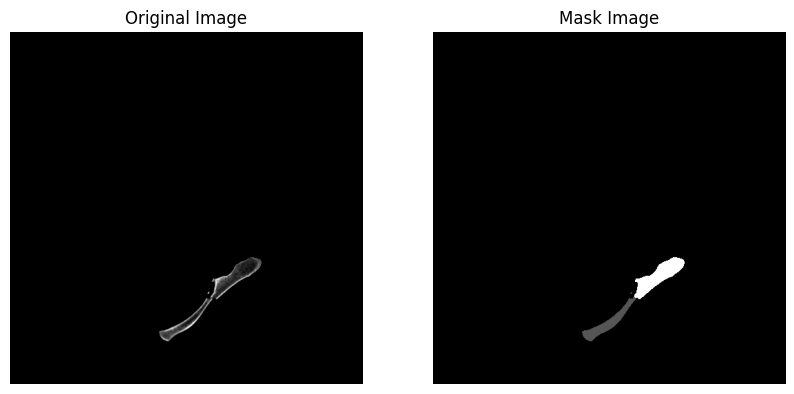

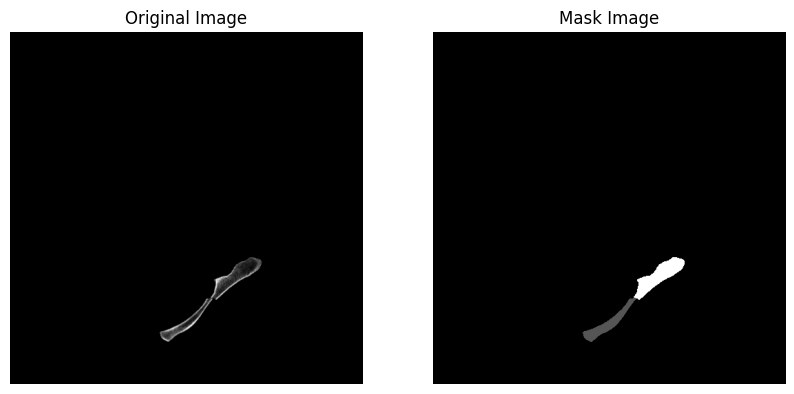

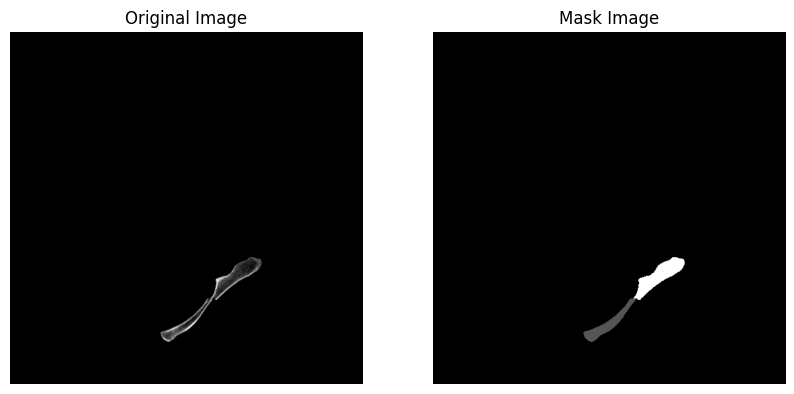

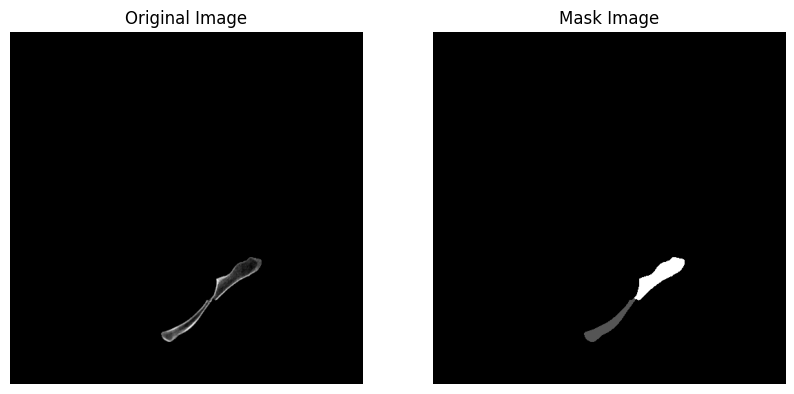

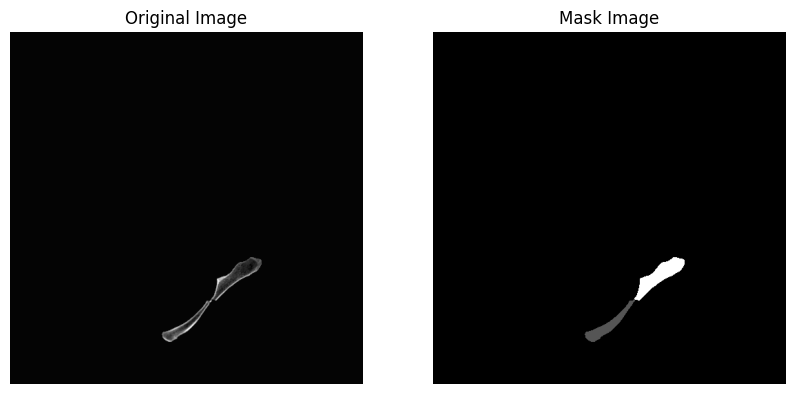

In [219]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

#loading left image:
img_l,mask_l=loadimages(image_dir_l,mask_dir_l)
# Process data using apt helper function
Xl, yl = PreprocessData(img_l, mask_l, target_shape_img, target_shape_mask, image_dir_l,mask_dir_l)

# QC the shape of output and classes in output dataset
print("X left Shape:", Xl.shape)
print("Y left shape:", yl.shape)

# Sample input array
label_values = np.unique(yl)
# Convert each value in the array to fall within the range [0, 3)

updclass=[]
for a in range(0,len(img_l)):
  for b in range(128):
    for c in range(128):
      for d in range(1):
        if yl[a,b,c,d]<0:
          yl[a,b,c,d]=0
        elif yl[a,b,c,d]>=0 and yl[a,b,c,d]<400:
          yl[a,b,c,d]=1
        else:
          yl[a,b,c,d]=2


print(np.unique(yl))

X Shape: (20, 128, 128, 3)
Y shape: (20, 128, 128, 1)
[0 1 2]


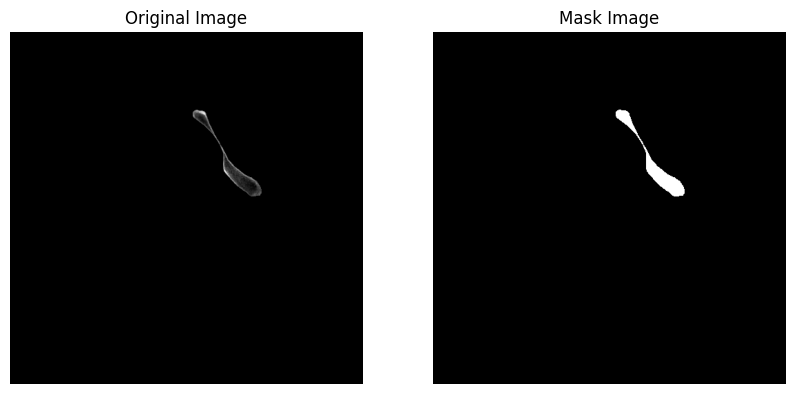

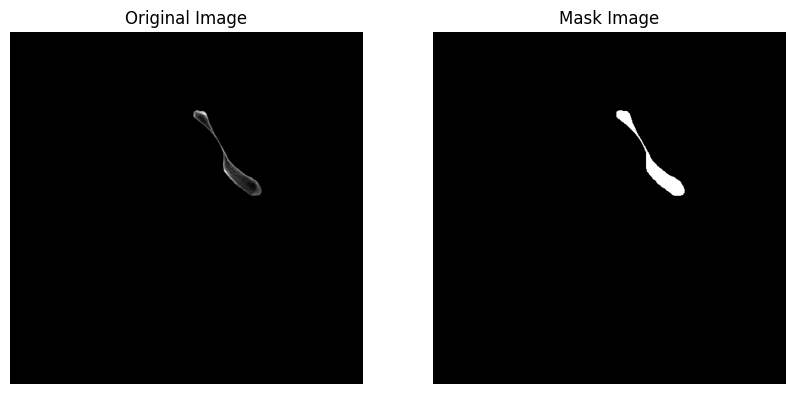

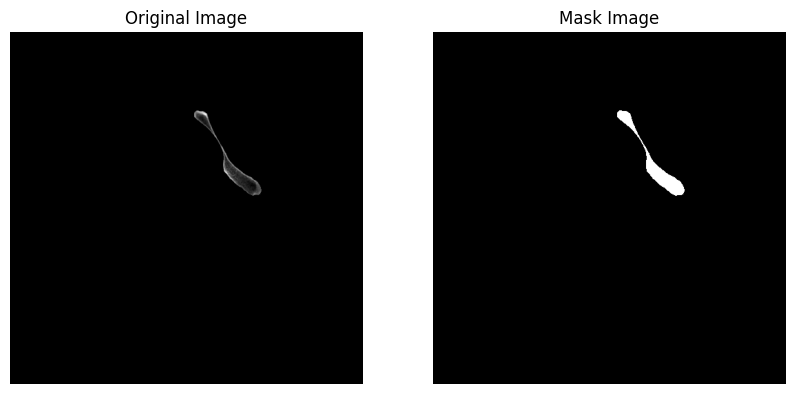

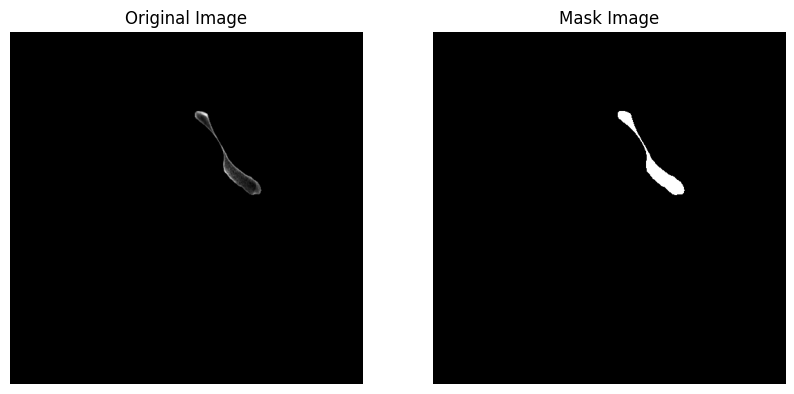

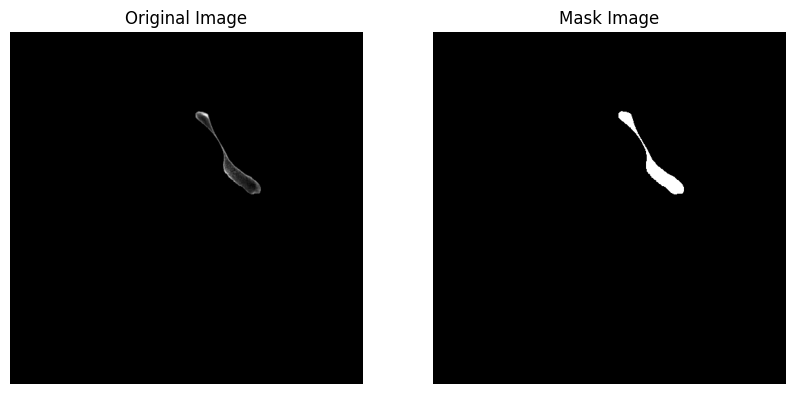

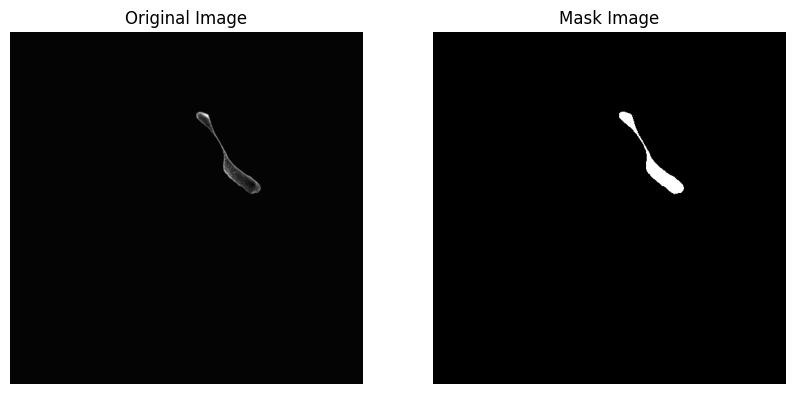

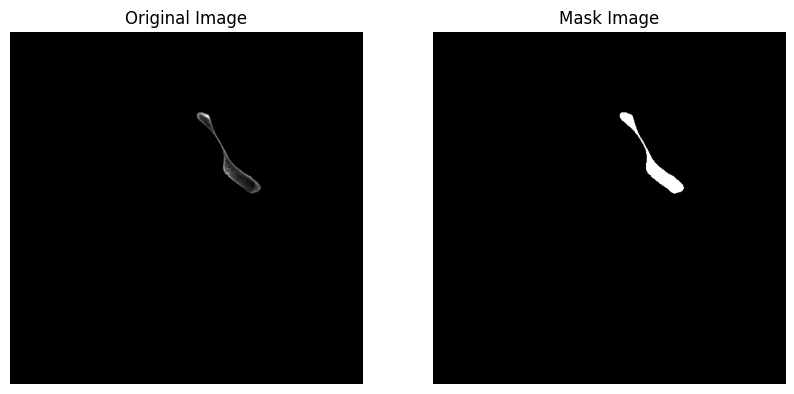

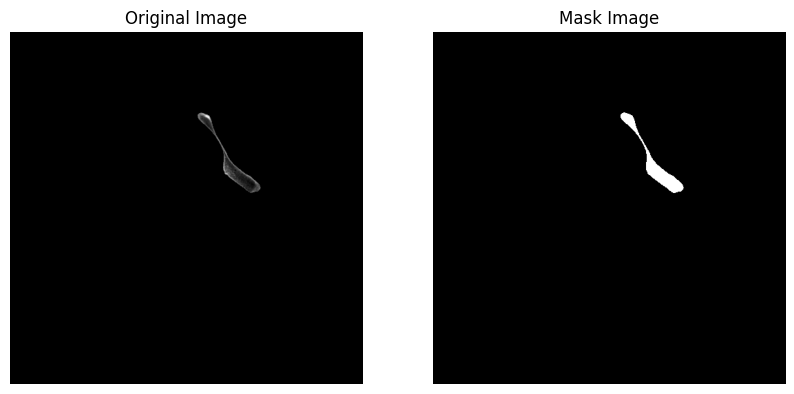

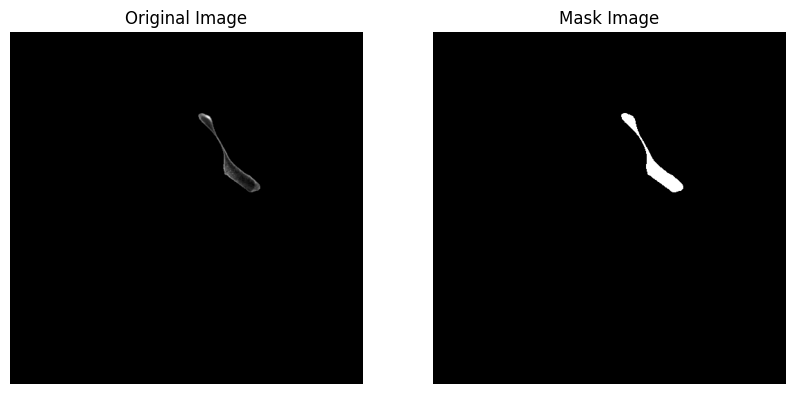

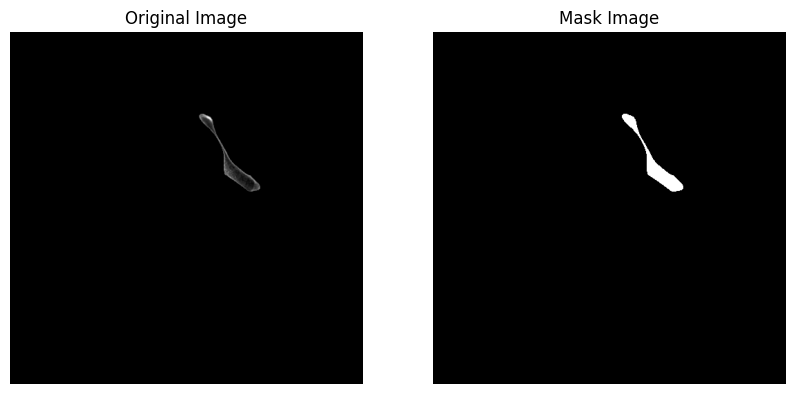

In [220]:
#processing right side image
img_r,mask_r=loadimages(image_dir_r,mask_dir_r)
Xr, yr = PreprocessData(img_r, mask_r, target_shape_img, target_shape_mask, image_dir_r,mask_dir_r)

# QC the shape of output and classes in output dataset
print("X Shape:", Xr.shape)
print("Y shape:", yr.shape)

# Sample input array
label_values = np.unique(yr)
# Convert each value in the array to fall within the range [0, 3)

updclass=[]
for a in range(0,len(img_r)):
  for b in range(128):
    for c in range(128):
      for d in range(1):
        if yr[a,b,c,d]<0:
          yr[a,b,c,d]=0
        elif yr[a,b,c,d]>=0 and yr[a,b,c,d]<400:
          yr[a,b,c,d]=1
        else:
          yr[a,b,c,d]=2


print(np.unique(yr))

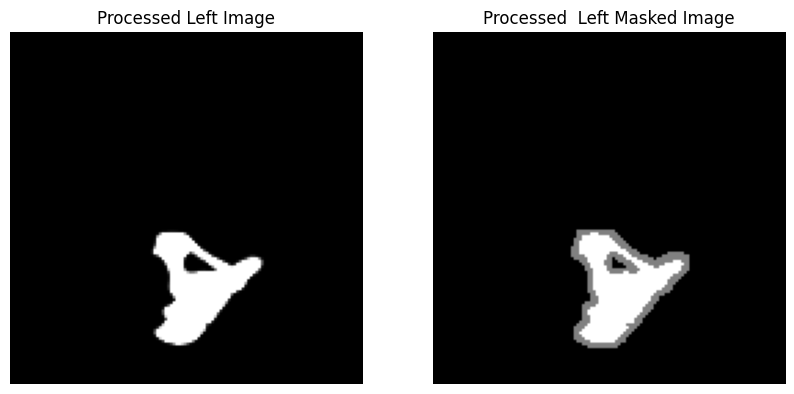

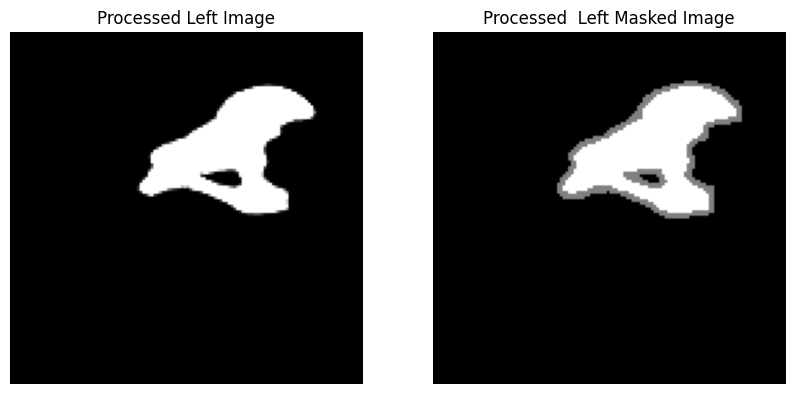

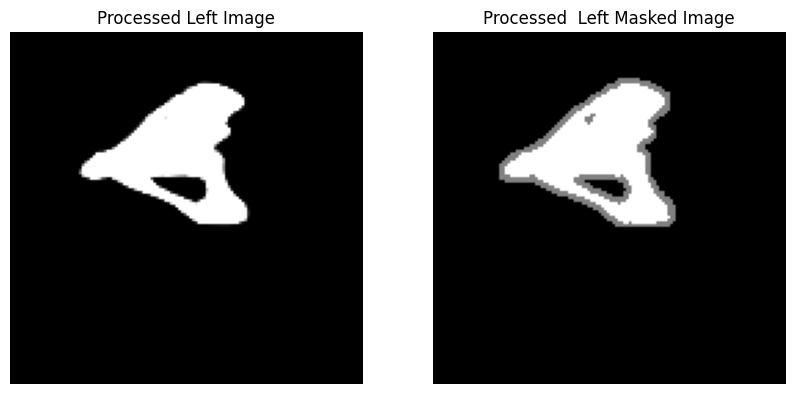

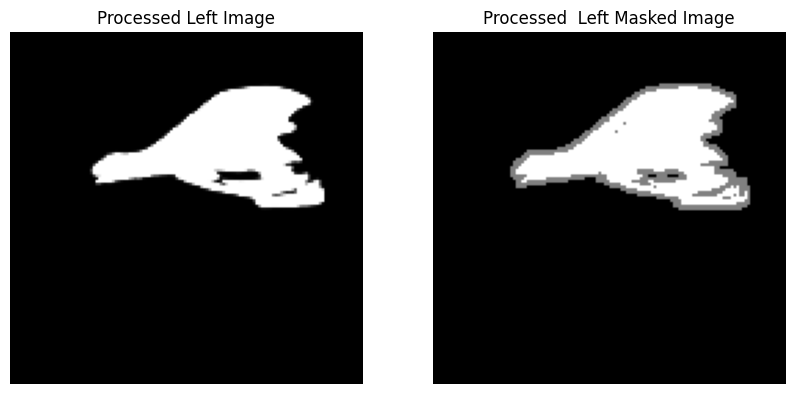

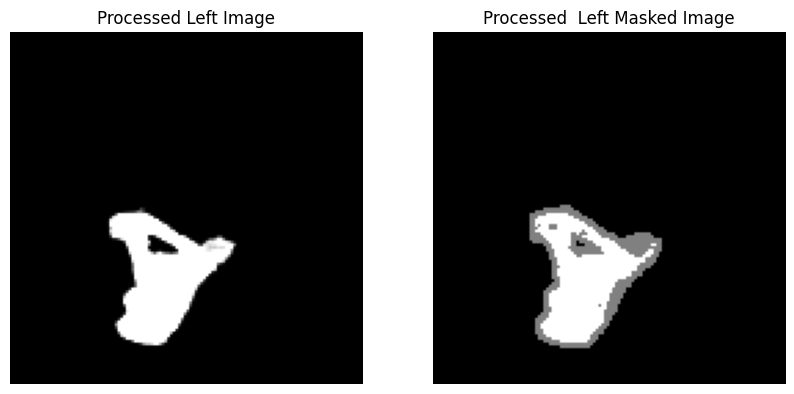

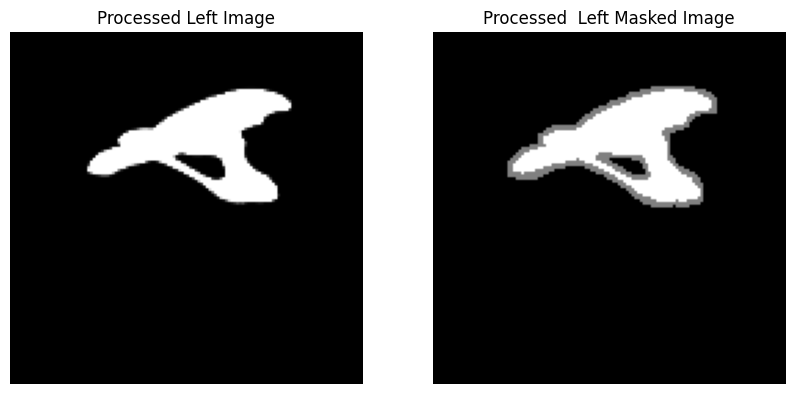

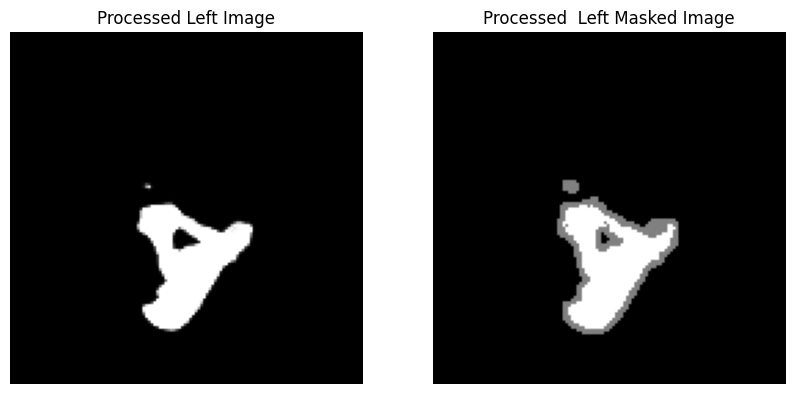

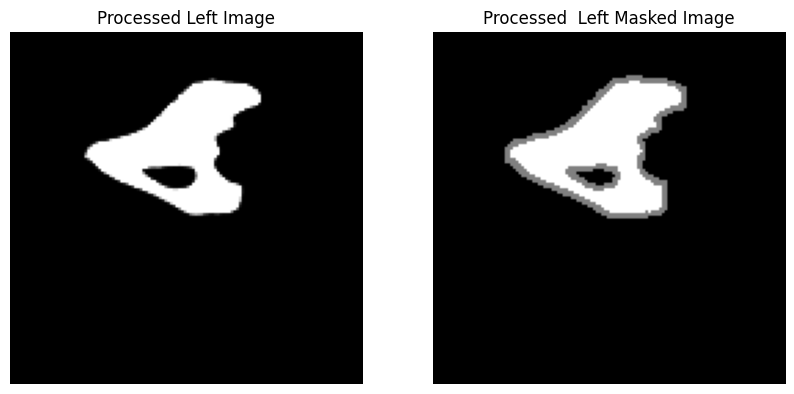

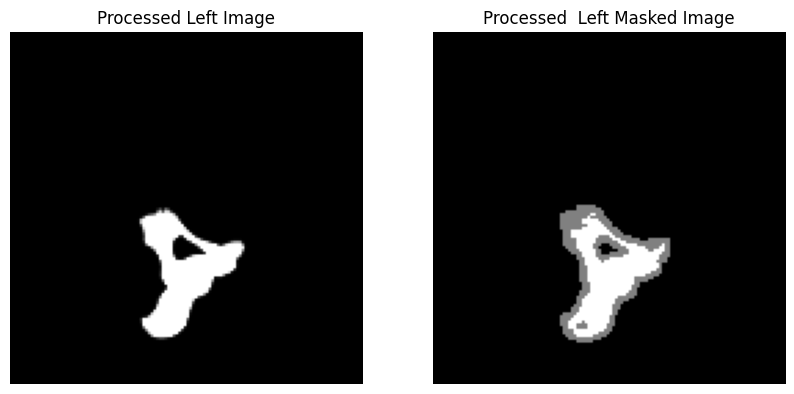

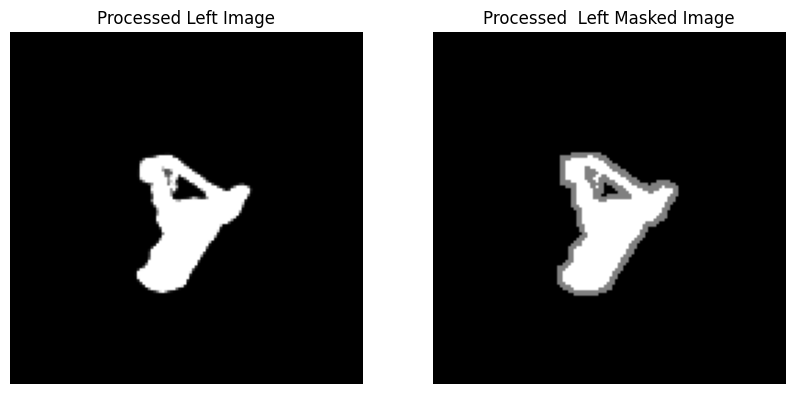

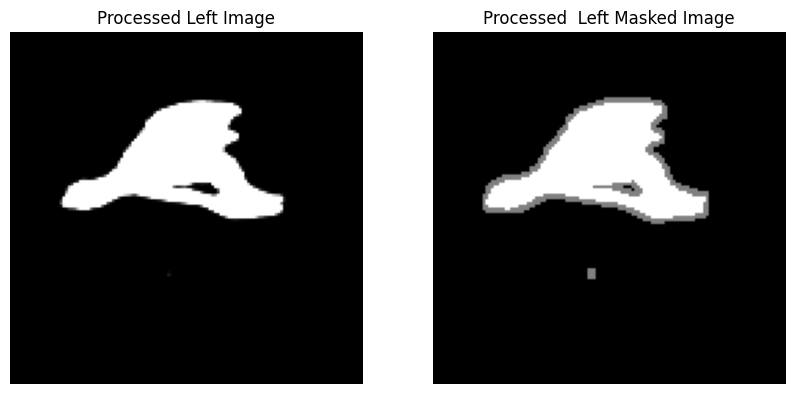

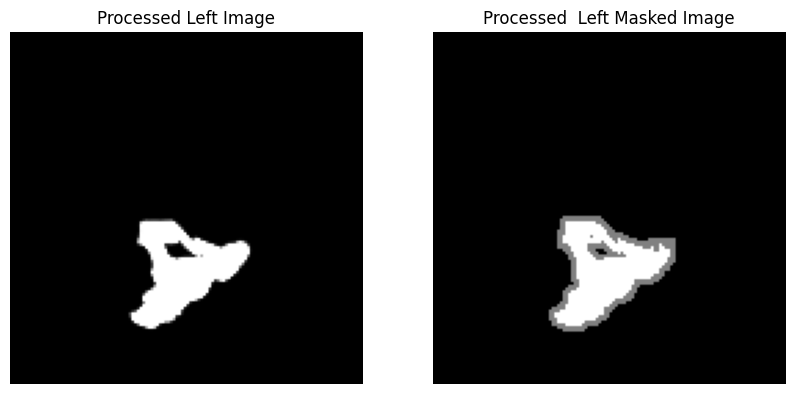

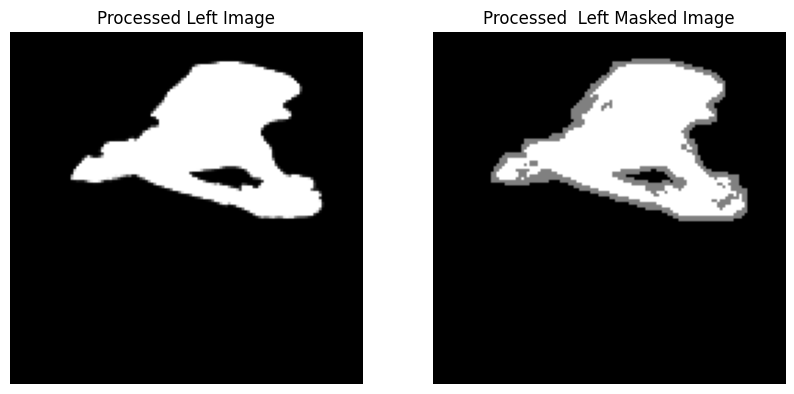

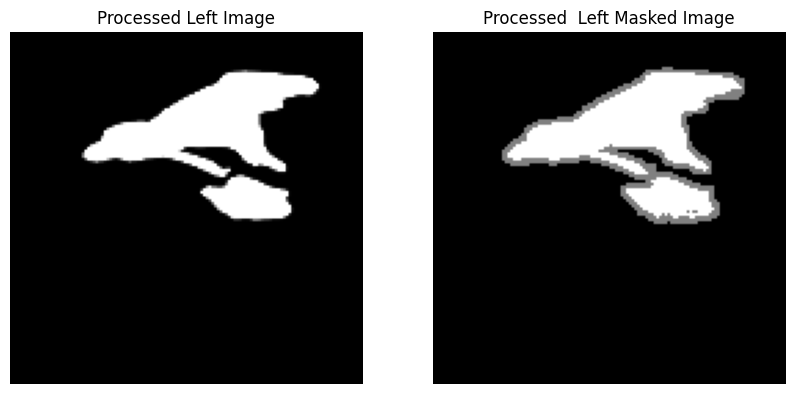

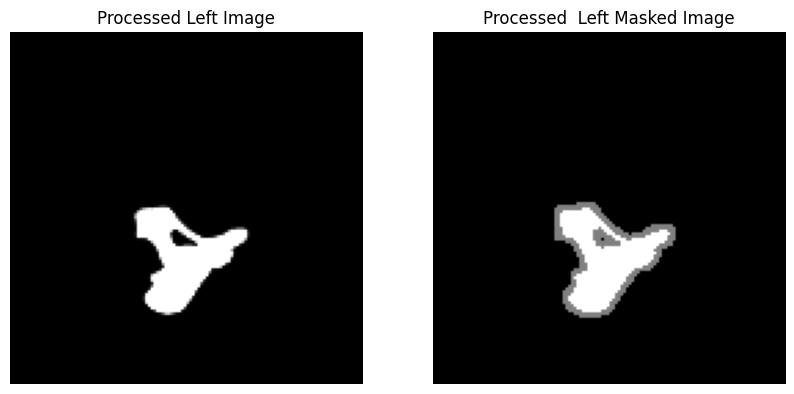

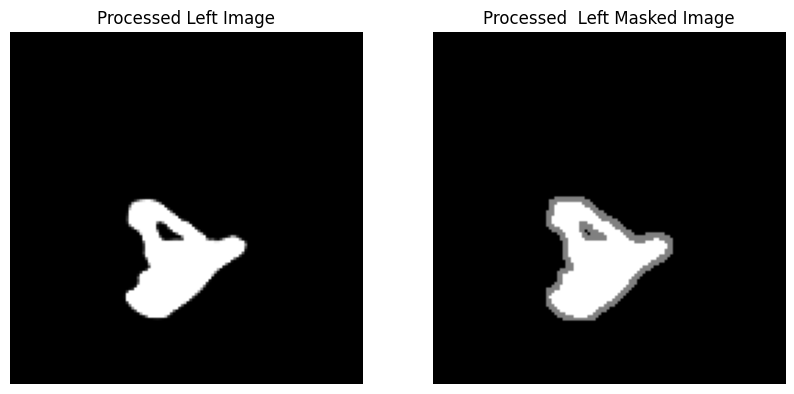

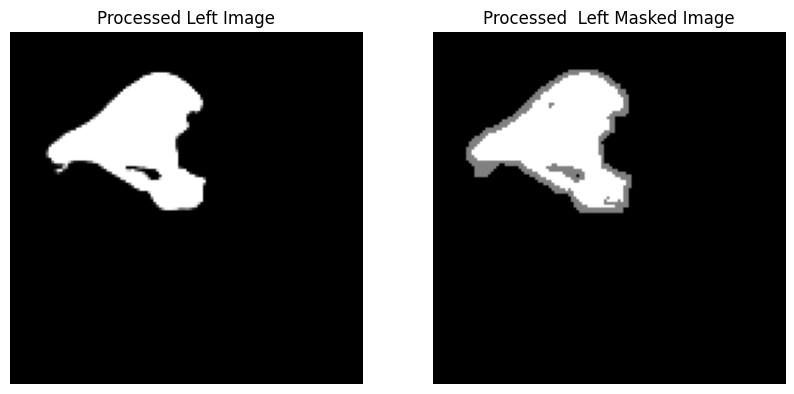

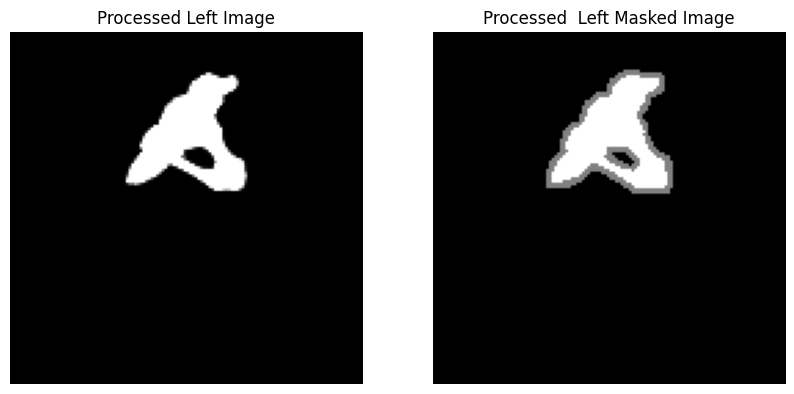

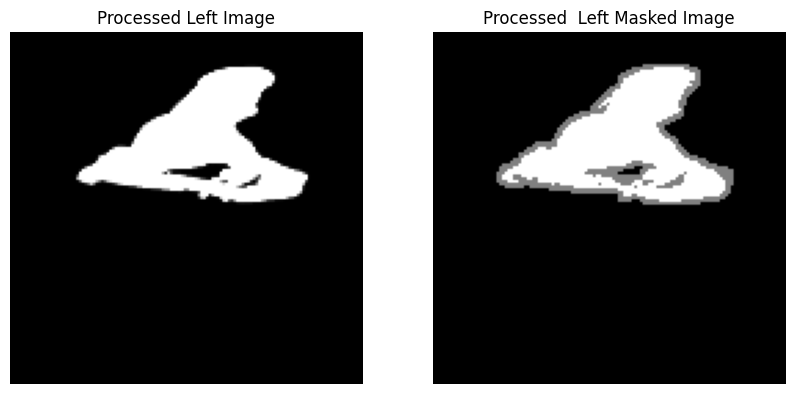

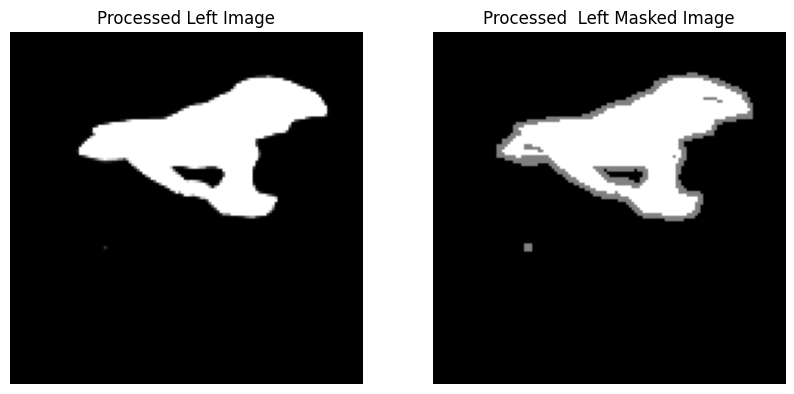

In [226]:

# Visualize the left output
for i in range(len(img_l)):
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(Xl[i],cmap='gray')
        plt.title('Processed Left Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(yl[i],cmap='gray')
        plt.title('Processed  Left Masked Image')
        plt.axis('off')

        plt.show()

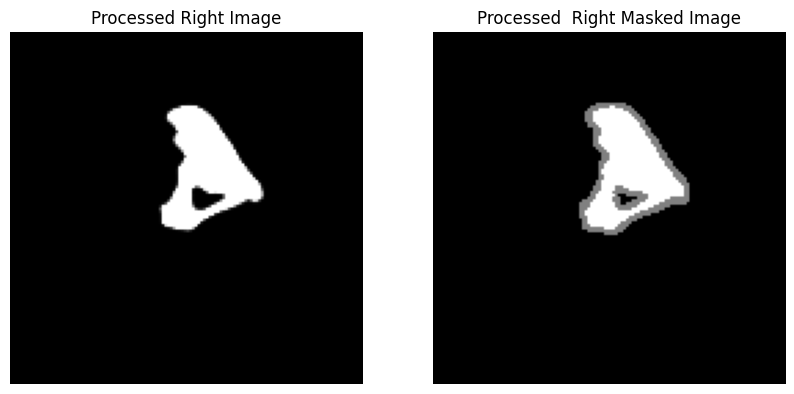

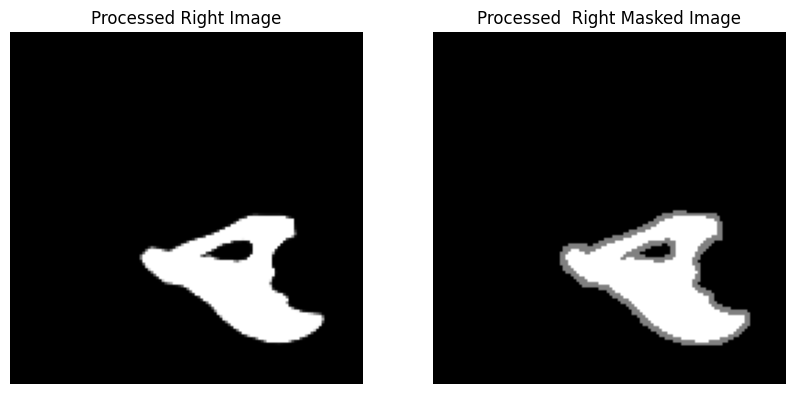

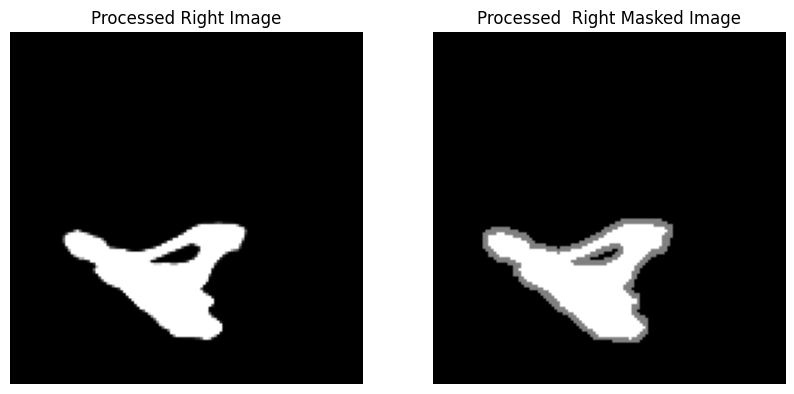

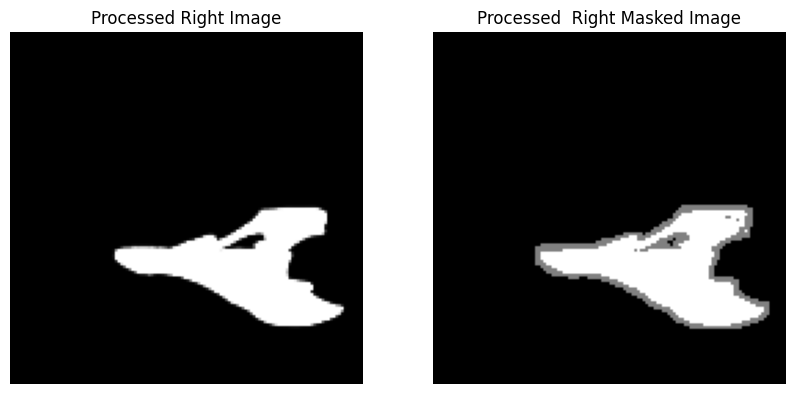

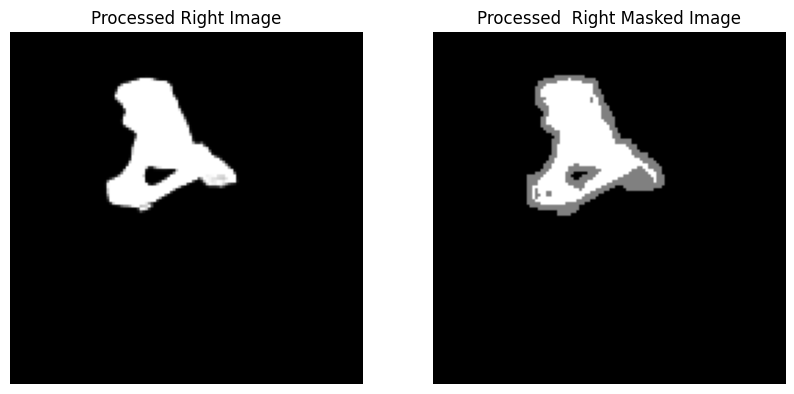

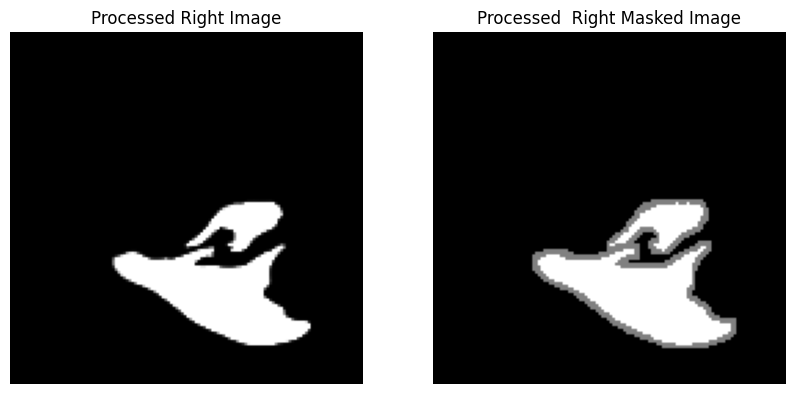

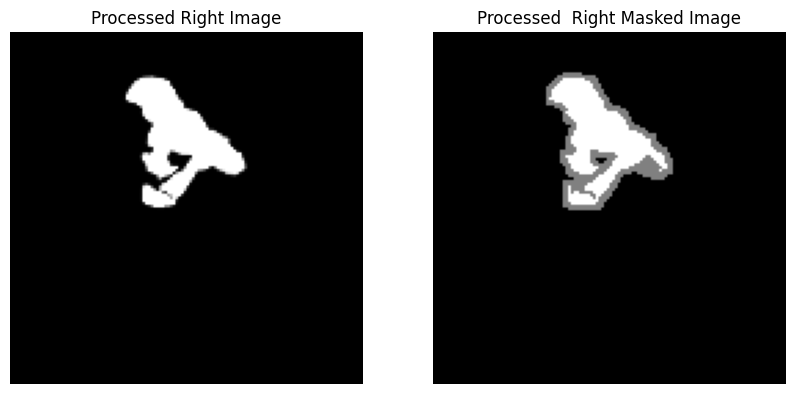

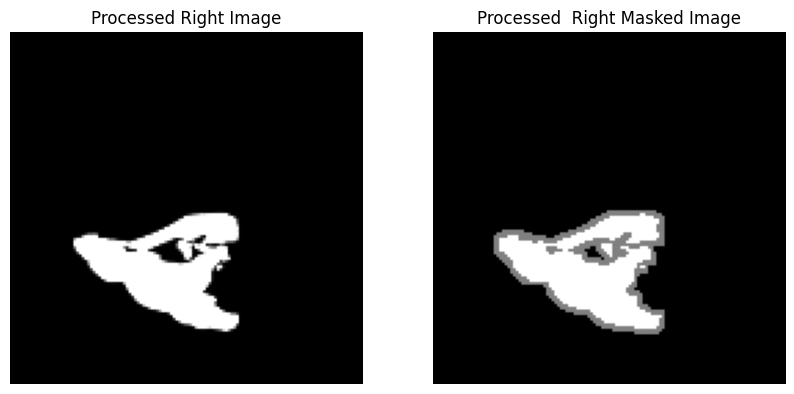

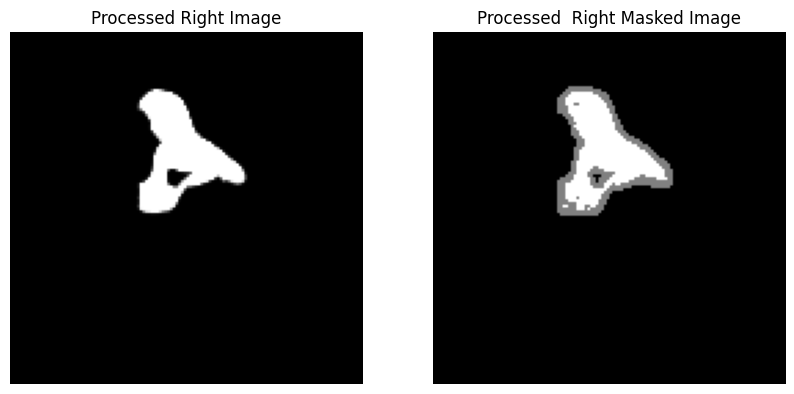

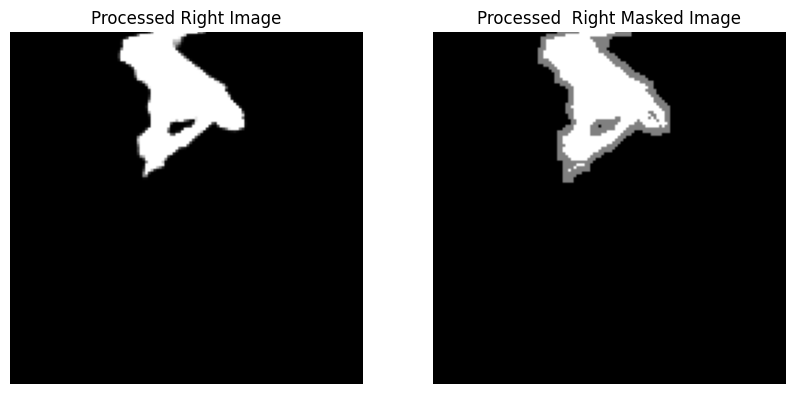

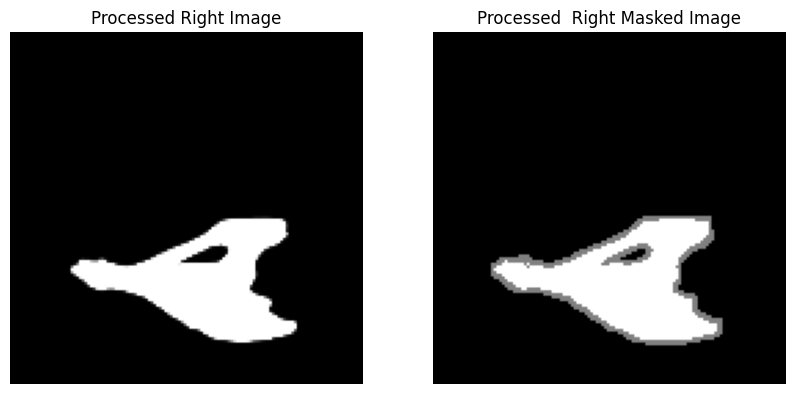

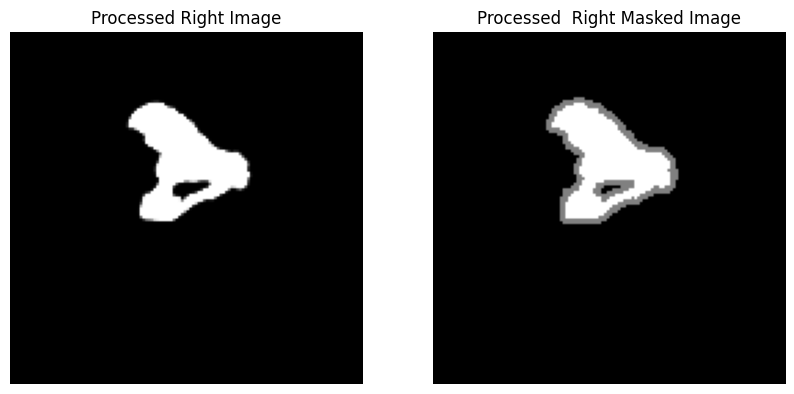

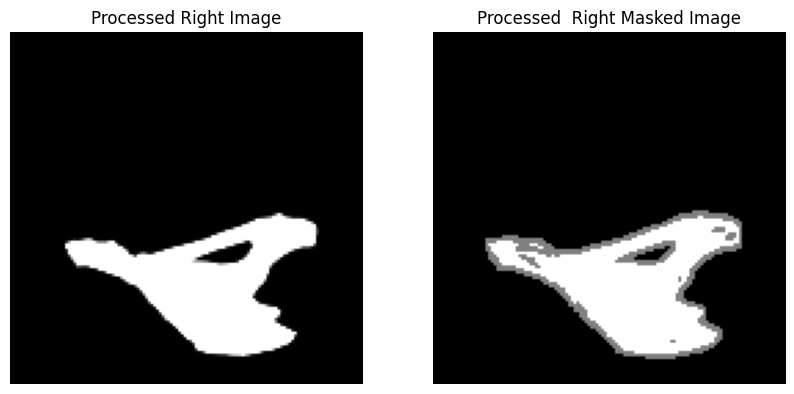

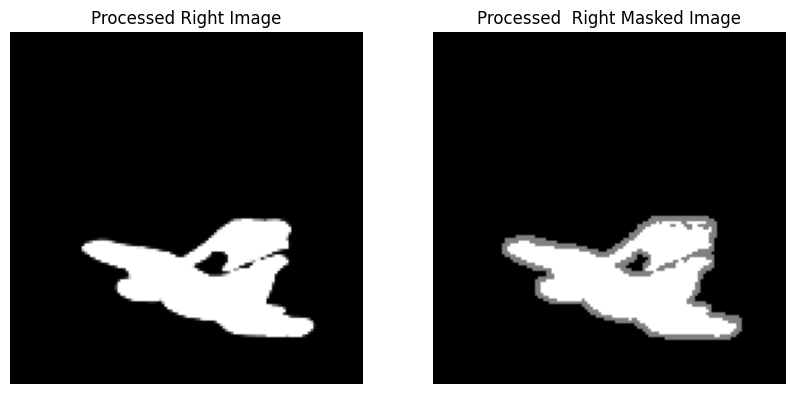

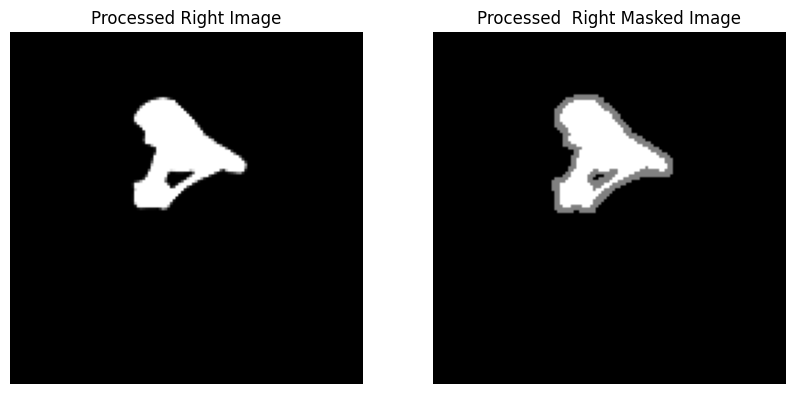

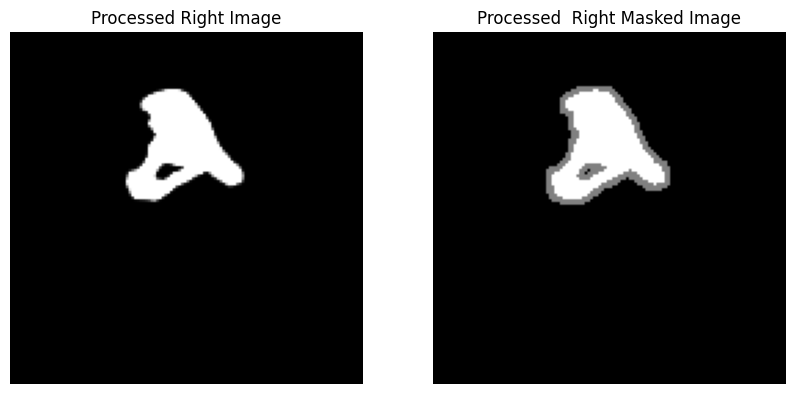

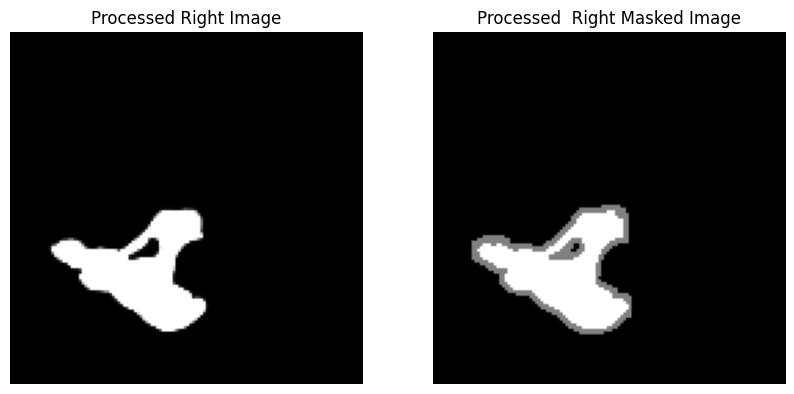

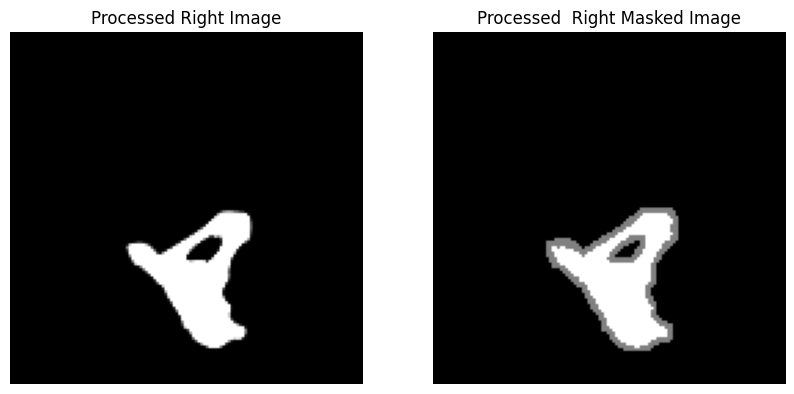

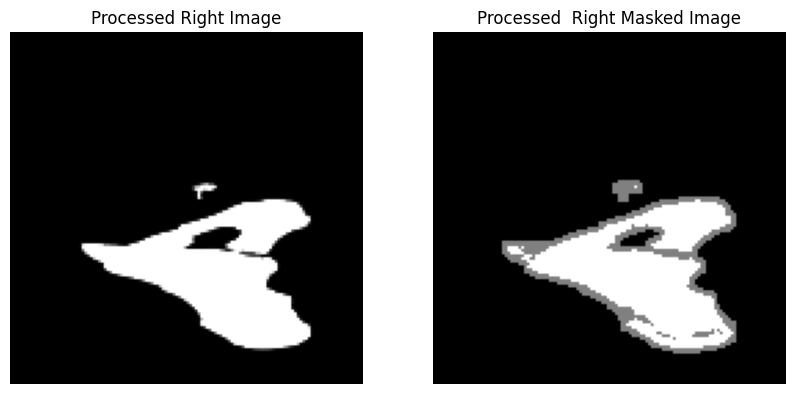

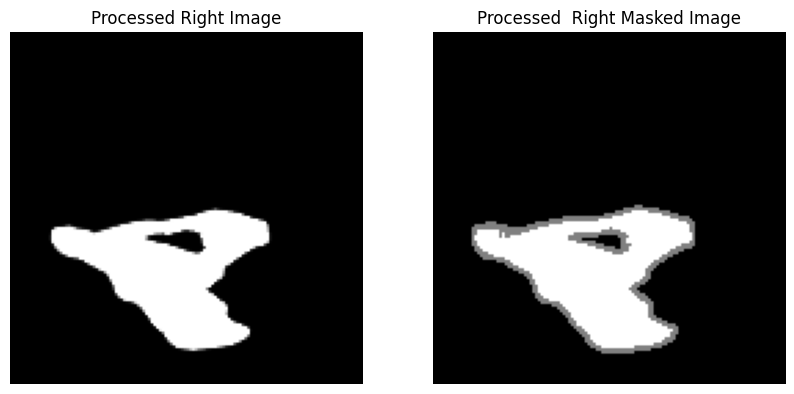

In [228]:

# Visualize the output
for i in range(len(img_r)):
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(Xr[i],cmap='gray')
        plt.title('Processed Right Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(yr[i],cmap='gray')
        plt.title('Processed  Right Masked Image')
        plt.axis('off')

        plt.show()


In [37]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set

#training left side images

Xl_train, Xl_valid, yl_train, yl_valid = train_test_split(Xl, yl, test_size=0.2, random_state=108)
print("Xl_train shape:", Xl_train.shape)
print("Xl_valid shape:", Xl_valid.shape)
print("yl_train shape:", yl_train.shape)
print("yl_valid shape:", yl_valid.shape)

Xl_train shape: (16, 128, 128, 3)
Xl_valid shape: (4, 128, 128, 3)
yl_train shape: (16, 128, 128, 1)
yl_valid shape: (4, 128, 128, 1)


In [38]:
#training right side images

Xr_train, Xr_valid, yr_train, yr_valid = train_test_split(Xr, yr, test_size=0.2, random_state=108)
print("Xr_train shape:", Xr_train.shape)
print("Xr_valid shape:", Xr_valid.shape)
print("yr_train shape:", yr_train.shape)
print("yr_valid shape:", yr_valid.shape)

Xr_train shape: (16, 128, 128, 3)
Xr_valid shape: (4, 128, 128, 3)
yr_train shape: (16, 128, 128, 1)
yr_valid shape: (4, 128, 128, 1)


In [52]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [ ]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [ ]:
# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

In [ ]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
from tensorflow.keras.optimizers import Adam

unet.compile(optimizer = tf.keras.optimizers.Adam(), loss='binary_crossentropy',metrics=['accuracy'])


In [ ]:
# Run the model in a mini-batch fashion and compute the progress for each epoch

#running model for left side segmented image
results = unet.fit(Xl_train, yl_train, batch_size=32, epochs=50, validation_data=(Xl_valid, yl_valid))

In [53]:
# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_50 (Conv2D)             (None, 128, 128, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_50[0][0]']              
                                )                                                           

In [60]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
from tensorflow.keras.optimizers import Adam

unet.compile(optimizer = tf.keras.optimizers.Adam(), loss='binary_crossentropy',metrics=['accuracy'])


In [61]:
# Run the model in a mini-batch fashion and compute the progress for each epoch

#running model for left side segmented image
results = unet.fit(Xl_train, yl_train, batch_size=32, epochs=50, validation_data=(Xl_valid, yl_valid))

Epoch 1/50
1/1 [==============================] - 9s 9s/step - loss: 2.1671 - accuracy: 0.2210 - val_loss: 2.5457 - val_accuracy: 0.1296
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 2.4029 - accuracy: 0.1080 - val_loss: 1.8501 - val_accuracy: 0.3640
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 1.5153 - accuracy: 0.3482 - val_loss: 1.3712 - val_accuracy: 0.6001
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 1.1058 - accuracy: 0.5833 - val_loss: 1.1169 - val_accuracy: 0.7038
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.9227 - accuracy: 0.6923 - val_loss: 0.6561 - val_accuracy: 0.7239
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 0.5658 - accuracy: 0.7144 - val_loss: 0.4020 - val_accuracy: 0.7670
Epoch 7/50
1/1 [==============================] - 3s 3s/step - loss: 0.3645 - accuracy: 0.7573 - val_loss: 0.3424 - val_accuracy: 0.8024
Epoch 8/50
1/1 [=========================

In [114]:
results_r = unet.fit(Xr_train, yr_train, batch_size=32, epochs=50, validation_data=(Xr_valid, yr_valid))

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: -1.0412 - accuracy: 0.8463 - val_loss: -1.3254 - val_accuracy: 0.8168
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: -1.0413 - accuracy: 0.8304 - val_loss: -1.3249 - val_accuracy: 0.8028
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: -1.0411 - accuracy: 0.8138 - val_loss: -1.3248 - val_accuracy: 0.7902
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: -1.0409 - accuracy: 0.7993 - val_loss: -1.3251 - val_accuracy: 0.7760
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: -1.0411 - accuracy: 0.7847 - val_loss: -1.3264 - val_accuracy: 0.7648
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: -1.0408 - accuracy: 0.7728 - val_loss: -1.3273 - val_accuracy: 0.7526
Epoch 7/50
1/1 [==============================] - 3s 3s/step - loss: -1.0410 - accuracy: 0.7594 - val_loss: -1.3285 - val_accuracy: 0.7328
Epoch 8/50
1/1 [===========

In [115]:
unet.evaluate(Xl_valid, yl_valid)


1/1 [==============================] - 0s 267ms/step - loss: -1.4291 - accuracy: 0.8676


[-1.4291129112243652, 0.8675537109375]

In [116]:
unet.evaluate(Xr_valid, yr_valid)


1/1 [==============================] - 0s 251ms/step - loss: -1.3392 - accuracy: 0.8767


[-1.3392226696014404, 0.876739501953125]

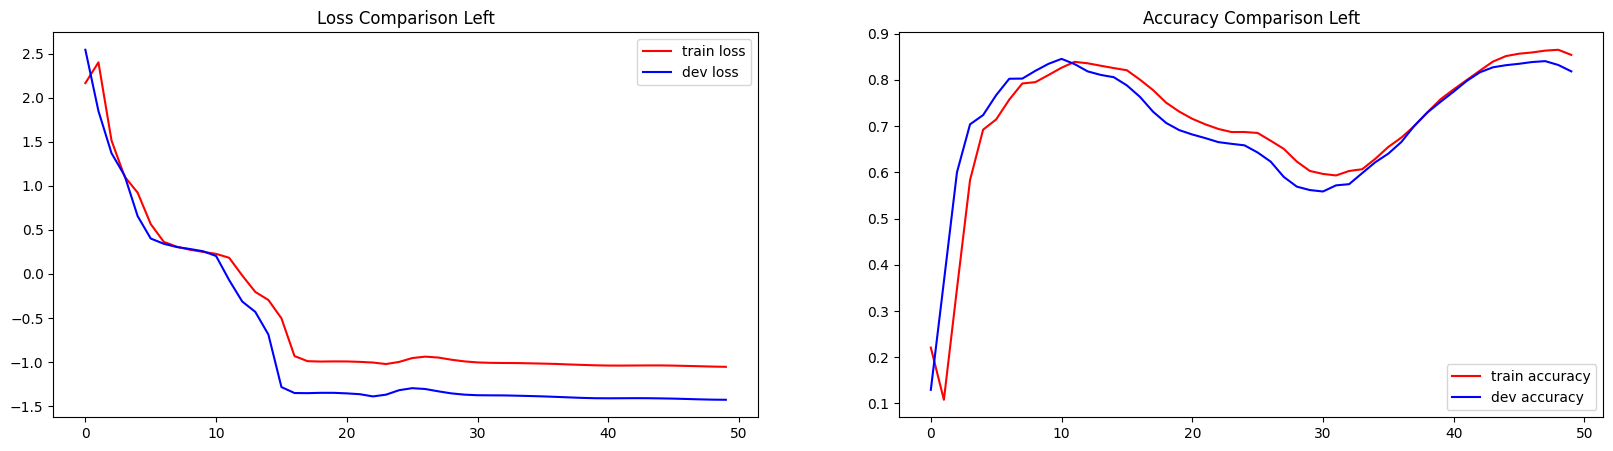

In [118]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison Left')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison Left')
axis[1].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

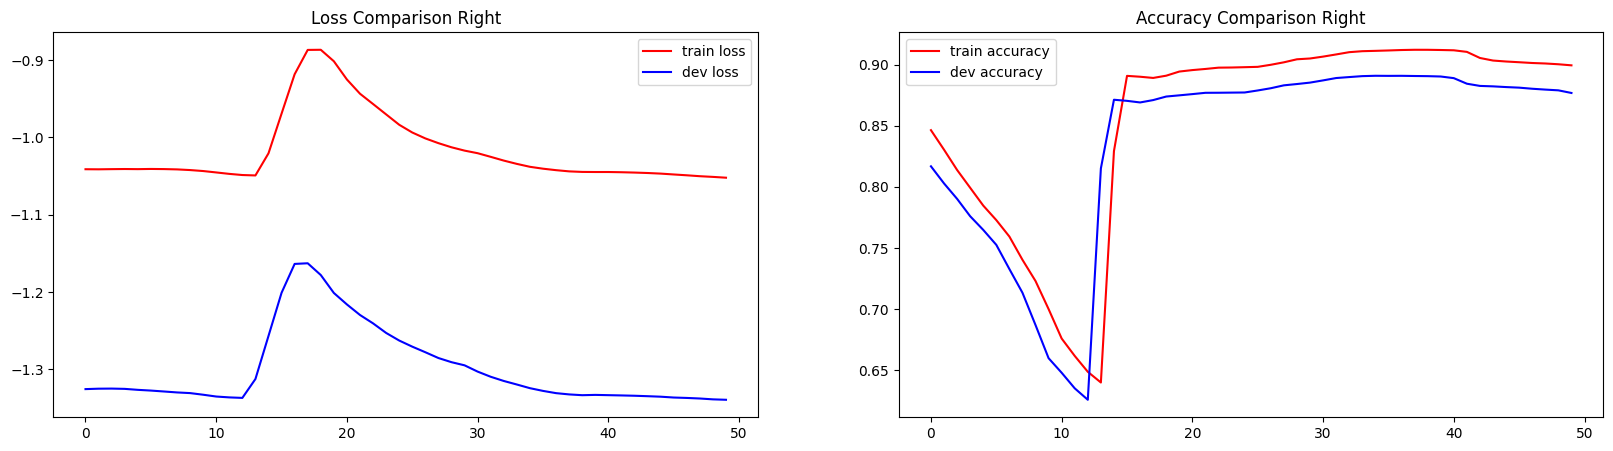

In [119]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results_r.history["loss"], color='r', label = 'train loss')
axis[0].plot(results_r.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison Right')
axis[0].legend()
axis[1].plot(results_r.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results_r.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison Right')
axis[1].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

1/1 [==============================] - 0s 306ms/step


(128, 128, 1)
Confusion Matrix:
[[13083   760   620]
 [    8   441    81]
 [    0  1390     1]]


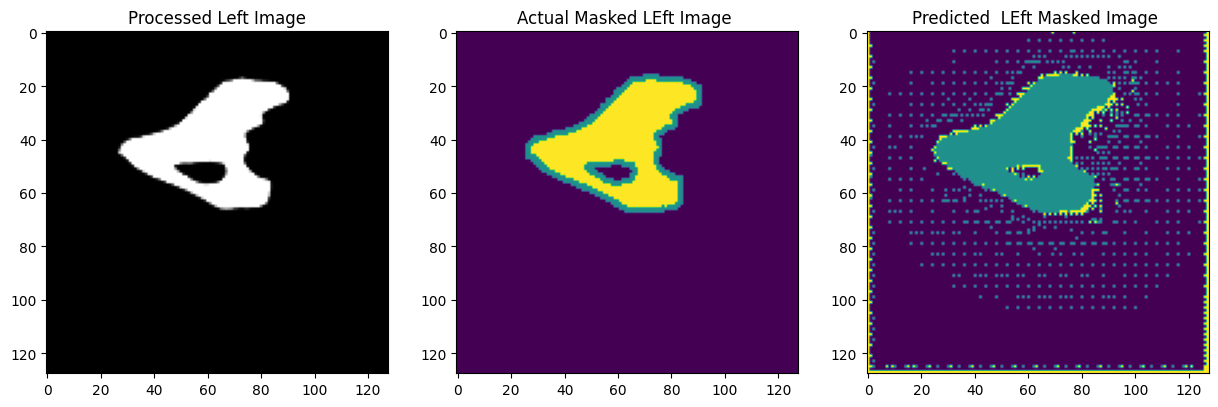

In [65]:
import numpy as np
from sklearn.metrics import confusion_matrix
# Results of Validation Dataset

def VisualizeResults(index):
    imgl = Xl_valid[index]
    imgl = imgl[np.newaxis, ...]
    pred_yl = unet.predict(imgl)
    pred_mask_l = tf.argmax(pred_yl[0], axis=-1)
    pred_mask_l = pred_mask_l[..., tf.newaxis]
    # Convert tensors to NumPy arrays
    actual_mask_flat_l = np.asarray(yl_valid[index].flatten())
    pred_mask_flat_l = np.asarray(pred_mask_l.numpy().flatten())

    # Compute confusion matrix
    confusion_mat_left = confusion_matrix(actual_mask_flat_l, pred_mask_flat_l)

    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(Xl_valid[index])
    arr[0].set_title('Processed Left Image')
    arr[1].imshow(yl_valid[index,:,:,0])
    arr[1].set_title('Actual Masked LEft Image ')
    arr[2].imshow(pred_mask_l[:,:,0])
    arr[2].set_title('Predicted  LEft Masked Image ')

    return pred_mask_l[:,:,], confusion_mat_left

# Example usage:
index = 0  # Set the index of the image you want to visualize
pred_mask_left, confusion_mat_left = VisualizeResults(index)
print(pred_mask_left.shape)
print("Confusion Matrix:")
print(confusion_mat_left)


1/1 [==============================] - 0s 168ms/step


(128, 128, 1)
Confusion Matrix:
[[14199    83   345]
 [   14   461    99]
 [    0  1181     2]]


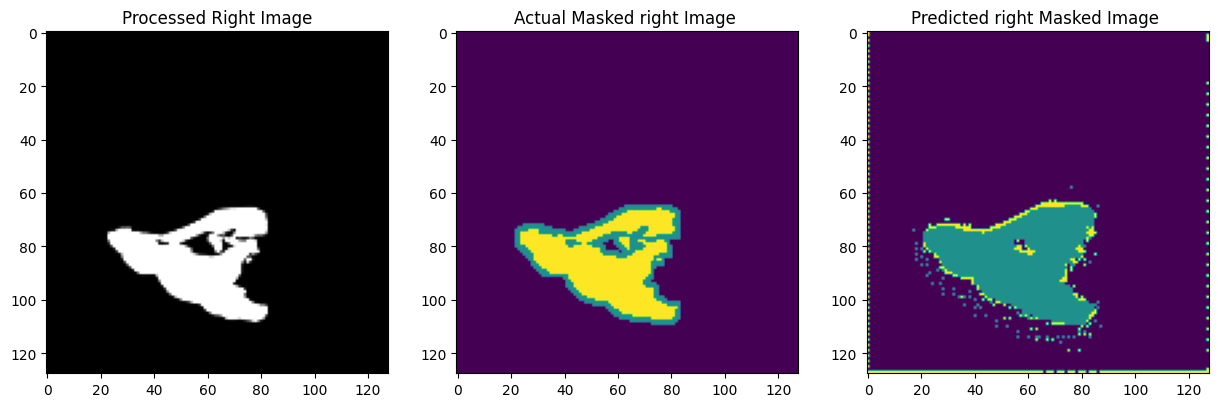

In [122]:
import numpy as np
from sklearn.metrics import confusion_matrix
# Results of Validation Dataset

def VisualizeResults(index):
    imgr = Xr_valid[index]
    imgr = imgr[np.newaxis, ...]
    pred_yr = unet.predict(imgr)
    pred_mask_r = tf.argmax(pred_yr[0], axis=-1)
    pred_mask_r = pred_mask_r[..., tf.newaxis]
    # Convert tensors to NumPy arrays
    actual_mask_flat_r = np.asarray(yr_valid[index].flatten())
    pred_mask_flat_r = np.asarray(pred_mask_r.numpy().flatten())

    # Compute confusion matrix
    confusion_mat_left = confusion_matrix(actual_mask_flat_r, pred_mask_flat_r)

    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(Xr_valid[index])
    arr[0].set_title('Processed Right Image')
    arr[1].imshow(yr_valid[index,:,:,0])
    arr[1].set_title('Actual Masked right Image ')
    arr[2].imshow(pred_mask_r[:,:,0])
    arr[2].set_title('Predicted right Masked Image ')

    return pred_mask_r[:,:,], confusion_mat_left

# Example usage:
index = 0  # Set the index of the image you want to visualize
pred_mask_right, confusion_mat_right = VisualizeResults(index)
print(pred_mask_right.shape)
print("Confusion Matrix:")
print(confusion_mat_right)


In [84]:
print(type(Xl_valid[index]))
# Print the minimum and maximum pixel values
print("Minimum pixel value:", np.min(Xl_valid[index]))
print("Maximum pixel value:", np.max(Xl_valid[index]))

<class 'numpy.ndarray'>
Minimum pixel value: 0.0
Maximum pixel value: 5.089307


In [123]:
print(type(Xr_valid[index]))
# Print the minimum and maximum pixel values
print("Minimum pixel value:", np.min(Xr_valid[index]))
print("Maximum pixel value:", np.max(Xr_valid[index]))

<class 'numpy.ndarray'>
Minimum pixel value: 0.0
Maximum pixel value: 5.0810103


(16384, 3)
(16384, 3)
Rotation matrix:
 [[ 0.99520297 -0.08060837  0.05543767]
 [-0.08070232 -0.35610834  0.93095327]
 [ 0.05530081  0.93096141  0.36090536]]
Translation vector:
 [-3.18594278e-04  8.08993925e-05  9.02425977e-05]


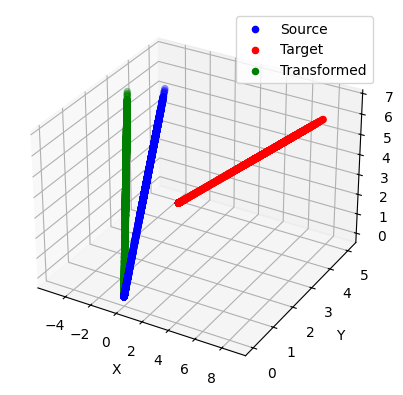

In [125]:
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

# Generate two point clouds (source and target)
source_points = Xl_valid[index] # Random source point cloud
rotation_matrix = Rotation.from_euler('xyz', [45, 30, 15], degrees=True).as_matrix()  # Rotation matrix
translation_vector = np.array([1, 2, 3])  # Translation vector
target_points = np.dot(Xr_valid[index], rotation_matrix.T) + translation_vector  # Apply transformation
# Assuming source and target are your arrays
source_points = source_points.reshape(-1, 3)
target_points = target_points.reshape(-1, 3)
# Function to perform Iterative Closest Point (ICP) registration
def icp_registration(source, target, max_iterations=50, tolerance=1e-6):
    for i in range(max_iterations):
        # Find nearest neighbors
        tree = KDTree(target)
        distances, indices = tree.query(source)
        
        # Corresponding points
        matched_target = target[indices]
        
        # Calculate transformation using SVD
        H = np.dot(source.T, matched_target)
        U, _, Vt = np.linalg.svd(H)
        R = np.dot(Vt.T, U.T)
        T = np.mean(matched_target - np.dot(source, R.T), axis=0)
        
        # Apply transformation
        source = np.dot(source, R.T) + T
        
        # Check convergence
        error = np.mean(distances)
        if error < tolerance:
            break
            
    return R, T
print(source_points.shape)
print(target_points.shape)
# Perform ICP registration
rotation_matrix, translation_vector = icp_registration(source_points, target_points)

# Print transformation matrix
print("Rotation matrix:\n", rotation_matrix)
print("Translation vector:\n", translation_vector)

# Apply transformation to source points
transformed_points = np.dot(source_points, rotation_matrix.T) + translation_vector

# Visualize the original and transformed point clouds
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(source_points[:,0], source_points[:,1], source_points[:,2], c='blue', label='Source')
ax.scatter(target_points[:,0], target_points[:,1], target_points[:,2], c='red', label='Target')
ax.scatter(transformed_points[:,0], transformed_points[:,1], transformed_points[:,2], c='green', label='Transformed')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()


In [ ]:
class_values_r=[]
class_values_l=[]
for a in range(0,len(img_r)):
  for b in range(128):
    for c in range(128):
      for d in range(1):
        class_values_r.append(yr[a,b,c,d])
        class_values_l.append(yl[a,b,c,d])
class_nparray_r=np.array(class_values_r[:128])
class_nparray_l=np.array(class_values_l[:128])


In [251]:
xx=Xr_valid[index,1]
print(xx)

[[-0. -0. -0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. 

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

# Generate synthetic dataset
X = xx

# DBSCAN clustering on original data
epsilon = 0.3  # Radius of neighborhood
min_samples = 10  # Minimum number of points required to form a dense region
dbscan_original = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_original.fit(X)
labels_original = class_nparray_r
# Apply spatial transformation (rotation only for demonstration)
rotation_matrix = rotation_matrix  # Rotation matrix
translation_vector = transformed_points  # Translation vector

# Transform points using homogeneous coordinates
X_homogeneous = np.hstack([X, np.ones((X.shape[0], 1))])  # Convert to homogeneous coordinates
X_transformed_homogeneous = transformed_points  # Apply transformation
X_transformed = X_transformed_homogeneous[:, :3]  # Convert back to Cartesian coordinates

# DBSCAN clustering on transformed data
dbscan_transformed = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_transformed.fit(X_transformed)
labels_transformed = class_nparray_l
print(type(labels_original))
# Compare the clustering labels
print("Original DBSCAN labels:", labels_original)
print("Transformed DBSCAN labels:", labels_transformed)

# Plot original and transformed data points with their clustering labels
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=class_nparray_r, cmap='viridis', marker='.', edgecolor='black', s=50)
plt.title('Original DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=class_nparray_l, cmap='viridis', marker='.', edgecolor='black', s=50)
plt.title('Transformed DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

# Check if the clustering labels are the same
if np.array_equal(labels_original, labels_transformed):
    print("DBSCAN clustering labels remain the same after transformation.")
else:
    print("DBSCAN clustering labels change after transformation.")

In [ ]:
import numpy as np
import nibabel as nib

# Step 1: Load NIfTI file and obtain Hounsfield Unit (HU) values
def load_nifti_data(file_path):
    nii_img = nib.load(file_path)
    data = nii_img.get_fdata()
    return data, nii_img.header.get_zooms()

# Step 2: Identify bone regions (example thresholding)
def identify_bone_regions(image, threshold):
    bone_mask = image >= threshold
    return bone_mask

# Step 3: Calculate average HU value for bone regions
def calculate_average_hu(image, bone_mask):
    bone_hu_values = image[bone_mask]
    average_hu = np.mean(bone_hu_values)
    return average_hu

# Step 4: Convert HU to bone density (if needed)
def convert_hu_to_density(average_hu):
    # Conversion formula or lookup table for HU to density conversion
    # Example: density = (HU - 1000) / 1000
    bone_density = (average_hu - 1000) / 1000
    return bone_density

# Example usage
file_path = "C:\\Users\\Dharuneswar Kumar\\Downloads\\left\\limg\\005_LI.nii"
image, voxel_size = load_nifti_data(file_path)
# Rescale voxel size to ensure consistent units (e.g., from mm to cm)
image = image.astype(np.float32)
voxel_volume = np.prod(voxel_size)  # Calculate voxel volume in cubic millimeters
threshold = 200  # Example threshold for bone tissue
bone_mask = identify_bone_regions(image, threshold)
average_hu = calculate_average_hu(image, bone_mask)
bone_density = convert_hu_to_density(average_hu)
print("Average HU value of bone:", average_hu)
print("Bone density:", bone_density)


In [ ]:
import numpy as np
import nibabel as nib

# Step 1: Load NIfTI file and obtain Hounsfield Unit (HU) values
def load_nifti_data(file_path):
    nii_img = nib.load(file_path)
    data = nii_img.get_fdata()
    return data, nii_img.header.get_zooms()

# Step 2: Identify bone regions (example thresholding)
def identify_bone_regions(image, threshold):
    bone_mask = image >= threshold
    return bone_mask

# Step 3: Calculate average HU value for bone regions
def calculate_average_hu(image, bone_mask):
    bone_hu_values = image[bone_mask]
    average_hu = np.mean(bone_hu_values)
    return average_hu

# Step 4: Convert HU to bone density (if needed)
def convert_hu_to_density(average_hu):
    # Conversion formula or lookup table for HU to density conversion
    # Example: density = (HU - 1000) / 1000
    bone_density = (average_hu - 1000) / 1000
    return bone_density

# Example usage
file_path = "C:\\Users\\Dharuneswar Kumar\\Downloads\\right\\rimg\\005_RI.nii"
image, voxel_size = load_nifti_data(file_path)
# Rescale voxel size to ensure consistent units (e.g., from mm to cm)
image = image.astype(np.float32)
voxel_volume = np.prod(voxel_size)  # Calculate voxel volume in cubic millimeters
threshold = 200  # Example threshold for bone tissue
bone_mask = identify_bone_regions(image, threshold)
average_hu = calculate_average_hu(image, bone_mask)
bone_density = convert_hu_to_density(average_hu)
print("Average HU value of bone:", average_hu)
print("Bone density:", bone_density)


In [106]:
pip install open3d


Note: you may need to restart the kernel to use updated packages.


In [128]:
import os
import numpy as np
import nibabel as nib

# Step 1: Load NIfTI file and obtain Hounsfield Unit (HU) values
def load_nifti_data(file_path):
    nii_img = nib.load(file_path)
    data = nii_img.get_fdata()
    return data, nii_img.header.get_zooms()

# Step 2: Identify bone regions (example thresholding)
def identify_bone_regions(image, threshold):
    bone_mask = image >= threshold
    return bone_mask

# Step 3: Calculate average HU value for bone regions
def calculate_average_hu(image, bone_mask):
    bone_hu_values = image[bone_mask]
    average_hu = np.mean(bone_hu_values)
    return average_hu

# Step 4: Convert HU to bone density (if needed)
def convert_hu_to_density(average_hu):
    # Conversion formula or lookup table for HU to density conversion
    # Example: density = (HU - 1000) / 1000
    bone_density = (average_hu - 1000) / 1000
    return bone_density

# Define folder containing .nii files
folder_path = "C:\\Users\\Dharuneswar Kumar\\Downloads\\right\\rimg\\"

# List all .nii files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.nii')]

# Store density values in a dictionary
right_density_values = {}

# Iterate through each .nii file
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    image, voxel_size = load_nifti_data(file_path)
    image = image.astype(np.float32)
    voxel_volume = np.prod(voxel_size)
    threshold = 200  # Example threshold for bone tissue
    bone_mask = identify_bone_regions(image, threshold)
    average_hu = calculate_average_hu(image, bone_mask)
    bone_density_rt = convert_hu_to_density(average_hu)
    right_density_values[file_name] = bone_density_rt

# Print or use density_values dictionary as needed
for file_name, density in density_values.items():
    print(f"{file_name}: Bone density = {density}")


001_LI.nii: Bone density = -0.5641644592285157
002_LI.nii: Bone density = -0.47011175537109373
003_LI.nii: Bone density = -0.500670654296875
004_LI.nii: Bone density = -0.4732578125
005_LI.nii: Bone density = -0.5819579467773438
006_LI.nii: Bone density = -0.44324798583984376
007_LI.nii: Bone density = -0.5082651672363281
008_LI.nii: Bone density = -0.504541015625
009_LI.nii: Bone density = -0.5578351440429687
010_LI.nii: Bone density = -0.4948194580078125
011_LI.nii: Bone density = -0.46118115234375
012_LI.nii: Bone density = -0.5185377502441406
013_LI.nii: Bone density = -0.5056592102050781
014_LI.nii: Bone density = -0.48000518798828123
015_LI.nii: Bone density = -0.4882569885253906
016_LI.nii: Bone density = -0.5285023193359375
017_LI.nii: Bone density = -0.5112477722167968
018_LI.nii: Bone density = -0.47834161376953127
019_LI.nii: Bone density = -0.5150821838378906
020_LI.nii: Bone density = -0.5173075256347657


In [130]:
import os
import numpy as np
import nibabel as nib

# Step 1: Load NIfTI file and obtain Hounsfield Unit (HU) values
def load_nifti_data(file_path):
    nii_img = nib.load(file_path)
    data = nii_img.get_fdata()
    return data, nii_img.header.get_zooms()

# Step 2: Identify bone regions (example thresholding)
def identify_bone_regions(image, threshold):
    bone_mask = image >= threshold
    return bone_mask

# Step 3: Calculate average HU value for bone regions
def calculate_average_hu(image, bone_mask):
    bone_hu_values = image[bone_mask]
    average_hu = np.mean(bone_hu_values)
    return average_hu

# Step 4: Convert HU to bone density (if needed)
def convert_hu_to_density(average_hu):
    # Conversion formula or lookup table for HU to density conversion
    # Example: density = (HU - 1000) / 1000
    bone_density = (average_hu - 1000) / 1000
    return bone_density

# Define folder containing .nii files
folder_path = "C:\\Users\\Dharuneswar Kumar\\Downloads\\left\\limg\\"

# List all .nii files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.nii')]

# Store density values in a dictionary
left_density_values = {}

# Iterate through each .nii file
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    image, voxel_size = load_nifti_data(file_path)
    image = image.astype(np.float32)
    voxel_volume = np.prod(voxel_size)
    threshold = 200  # Example threshold for bone tissue
    bone_mask = identify_bone_regions(image, threshold)
    average_hu = calculate_average_hu(image, bone_mask)
    bone_density = convert_hu_to_density(average_hu)
    left_density_values[file_name] = bone_density

# Print or use density_values dictionary as needed
for file_name, density in left_density_values.items():
    print(f"{file_name}: Bone density = {density}")


001_LI.nii: Bone density = -0.5641644592285157
002_LI.nii: Bone density = -0.47011175537109373
003_LI.nii: Bone density = -0.500670654296875
004_LI.nii: Bone density = -0.4732578125
005_LI.nii: Bone density = -0.5819579467773438
006_LI.nii: Bone density = -0.44324798583984376
007_LI.nii: Bone density = -0.5082651672363281
008_LI.nii: Bone density = -0.504541015625
009_LI.nii: Bone density = -0.5578351440429687
010_LI.nii: Bone density = -0.4948194580078125
011_LI.nii: Bone density = -0.46118115234375
012_LI.nii: Bone density = -0.5185377502441406
013_LI.nii: Bone density = -0.5056592102050781
014_LI.nii: Bone density = -0.48000518798828123
015_LI.nii: Bone density = -0.4882569885253906
016_LI.nii: Bone density = -0.5285023193359375
017_LI.nii: Bone density = -0.5112477722167968
018_LI.nii: Bone density = -0.47834161376953127
019_LI.nii: Bone density = -0.5150821838378906
020_LI.nii: Bone density = -0.5173075256347657


In [139]:
# Define a threshold for considering the difference as significant
threshold_difference = 0.025  # Adjust as needed

# Iterate through the left dictionary and compare densities
for left_file, left_density in left_density_values.items():
    # Extract the common number part from the left filename
    left_number = left_file.split('_')[0]  # Assuming the number is before the underscore
    
    # Create the corresponding right filename
    right_file = f"{left_number}_RI.nii"  # Assuming right filenames have the same number
    
    # Check if the corresponding right file exists in the right dictionary
    if right_file in right_density_values:
        # Get the density from the right dictionary
        right_density = right_density_values[right_file]
        
        # Calculate the density difference
        density_difference = abs(left_density - right_density)
        
        # Print a message if the difference exceeds the threshold
        if density_difference > threshold_difference:
            print(f"Possibility of fracture detected between {left_file} and {right_file}.")
            print(f"Density difference: {density_difference}")
        else:
            print(f"NO Possibility of fracture detected between {left_file} and {right_file}.")



NO Possibility of fracture detected between 001_LI.nii and 001_RI.nii.
NO Possibility of fracture detected between 002_LI.nii and 002_RI.nii.
NO Possibility of fracture detected between 003_LI.nii and 003_RI.nii.
Possibility of fracture detected between 004_LI.nii and 004_RI.nii.
Density difference: 0.02589007568359375
NO Possibility of fracture detected between 005_LI.nii and 005_RI.nii.
Possibility of fracture detected between 006_LI.nii and 006_RI.nii.
Density difference: 0.048938323974609343
NO Possibility of fracture detected between 007_LI.nii and 007_RI.nii.
NO Possibility of fracture detected between 008_LI.nii and 008_RI.nii.
NO Possibility of fracture detected between 009_LI.nii and 009_RI.nii.
Possibility of fracture detected between 010_LI.nii and 010_RI.nii.
Density difference: 0.03992022705078119
Possibility of fracture detected between 011_LI.nii and 011_RI.nii.
Density difference: 0.026706848144531226
NO Possibility of fracture detected between 012_LI.nii and 012_RI.nii

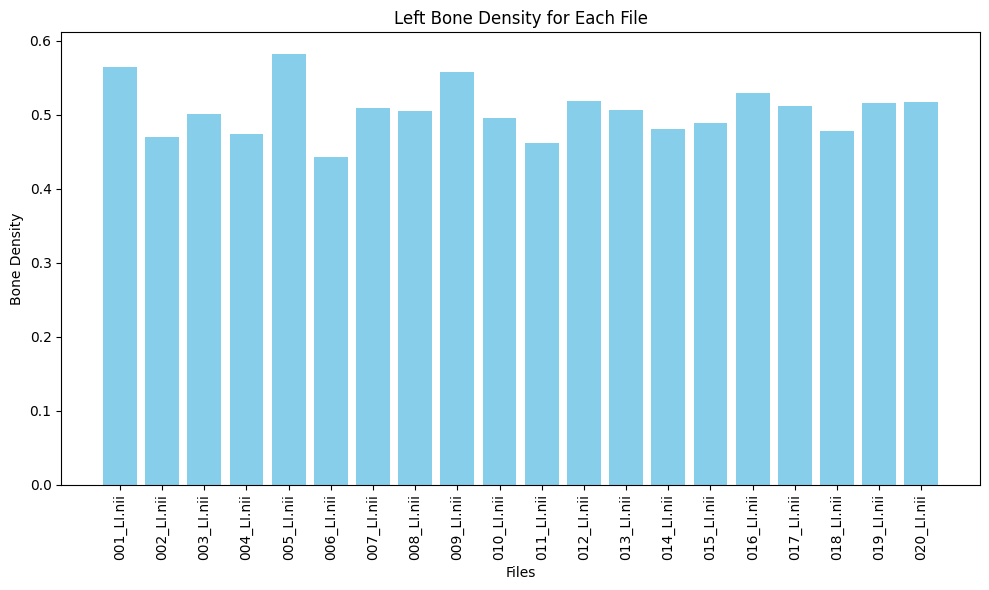

In [7]:
import matplotlib.pyplot as plt

# File names
files = [
    "001_LI.nii", "002_LI.nii", "003_LI.nii", "004_LI.nii", "005_LI.nii",
    "006_LI.nii", "007_LI.nii", "008_LI.nii", "009_LI.nii", "010_LI.nii",
    "011_LI.nii", "012_LI.nii", "013_LI.nii", "014_LI.nii", "015_LI.nii",
    "016_LI.nii", "017_LI.nii", "018_LI.nii", "019_LI.nii", "020_LI.nii"
]

# Bone density values
density_values = [
    -0.5641644592285157, -0.47011175537109373, -0.500670654296875,
    -0.4732578125, -0.5819579467773438, -0.44324798583984376,
    -0.5082651672363281, -0.504541015625, -0.5578351440429687,
    -0.4948194580078125, -0.46118115234375, -0.5185377502441406,
    -0.5056592102050781, -0.48000518798828123, -0.4882569885253906,
    -0.5285023193359375, -0.5112477722167968, -0.47834161376953127,
    -0.5150821838378906, -0.5173075256347657
]

# Invert density values
density_values_inverted = [-val for val in density_values]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(files, density_values_inverted, color='skyblue')
plt.xlabel('Files')
plt.ylabel('Bone Density')
plt.title('Left Bone Density for Each File')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
